## ROME - all models + obs

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

from os.path import expanduser
home = expanduser("~")

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [3]:
models = [
    'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     
    'GISS-E2-H',    # 3
    'bcc-csm1-1',   # 4
    'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 # cannot concatanate files for rcp85 run
    'HadGEM2-AO',   # 7
    'BNU-ESM',      # 8
    'EC-EARTH',     # 9
    'FGOALS-g2',    # 10
    'MPI-ESM-MR',   # 11
    'CMCC-CM',      # 12
    'inmcm4',       # 13
    'NorESM1-M',    # 14
    'CanESM2',      # 15
    'MIROC5',       # 16
    'HadGEM2-CC',   # 17
    'MRI-CGCM3',    # 18
    'CESM1-BGC'     # 19
    ]

model = models[0]


experiments = [
    'historical',
    # 'rcp85'
    ]
experiment = experiments[0]

obs = {'GPCP':True}


rome_options = [
    'rome',
    # 'rome_n'
    ]
rome_option = rome_options[0]

## climatology

### time mean

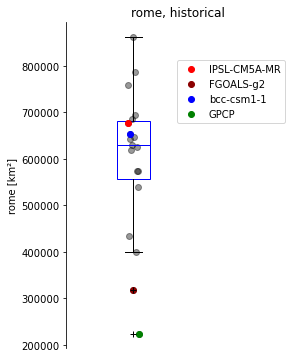

In [7]:
y= []
for model in models:
    folder = home + '/Documents/data/cmip5/' + model
    fileName = model + '_rome_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    y = np.append(y, ds[rome_option].mean(dim='time'))


if obs['GPCP']:
    folder = home + '/Documents/data/obs/GPCP'
    fileName = 'GPCP_rome.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    y = np.append(y, ds[rome_option].mean(dim='time'))



plt.figure(figsize=(4,6))
plt.xlim(0,1)
# plt.ylim(0.6e+6, 1.3e+6)

plt.boxplot(y,vert=True, positions= [0.3], patch_artist=True, medianprops = dict(color="b",linewidth=1),boxprops = dict(color="b",facecolor='w',zorder=0)
            ,sym='+',flierprops = dict(color="r"))


x = np.linspace(0.3-0.025, 0.3+0.025, len(y))
plt.scatter(x, y, c='k', alpha=0.4)
#plt.scatter(np.ones(len(y)), y)


x_leg = [models.index('IPSL-CM5A-MR'),models.index('FGOALS-g2'), models.index('bcc-csm1-1'), -1]
label = ['IPSL-CM5A-MR','FGOALS-g2','bcc-csm1-1', 'GPCP']
colors = ['r','darkred','b', 'g']
j=0
for i in x_leg:
    plt.scatter(x[i],y[i],c=colors[j], label=label[j])
    j+=1


plt.xticks([])
plt.title(rome_option + ', ' + experiment)
plt.ylabel(rome_option + ' [km\u00b2]')
plt.legend(bbox_to_anchor=(0.6,0.5,0.4,0.4))

sns.despine(top=True, right=True, left=False, bottom=True)

### annual

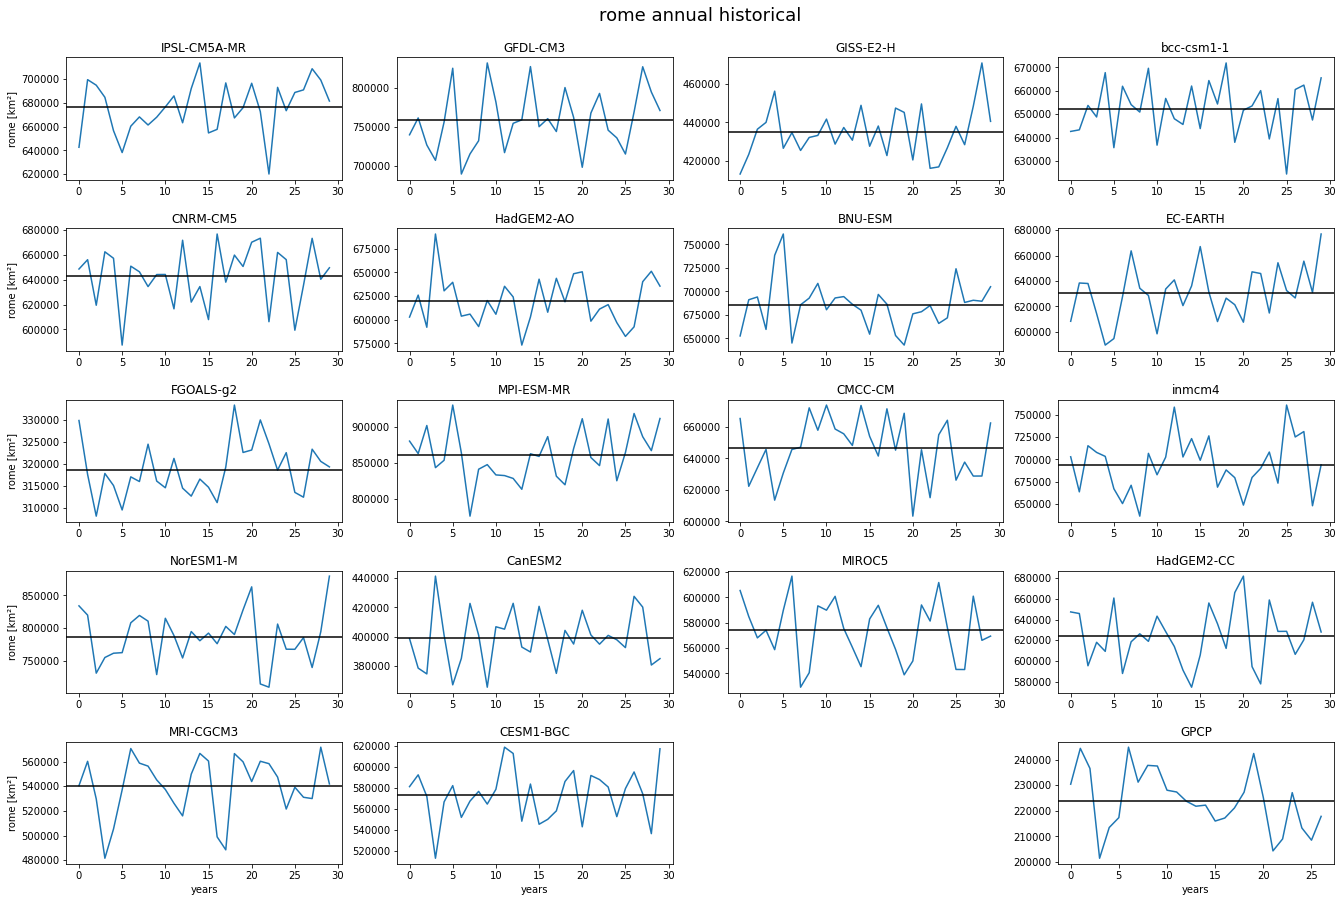

In [8]:
f, axes = plt.subplots(nrows=5, ncols=4, figsize = (22,14))
f.suptitle(rome_option + ' annual, ' + experiment, fontsize=18, y=0.95)

for model, ax in zip(models, axes.ravel()):

    folder = home + '/Documents/data/cmip5/' + model
    fileName = model + '_rome_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)

    ax.plot(ds[rome_option].resample(time='Y').mean(dim='time'))
    ax.axhline(y=ds[rome_option].resample(time='Y').mean(dim='time').mean(dim='time'), color='k')
    ax.set_title(model)

    if model == 'MRI-CGCM3' or model == 'CESM1-BGC':
        ax.set_xlabel('years')

    if model == 'IPSL-CM5A-MR' or model == 'CNRM-CM5' or model == 'FGOALS-g2' or model == 'NorESM1-M' or model == 'MRI-CGCM3': 
        ax.set_ylabel(rome_option + ' [km\u00b2]')


if obs['GPCP']:
    ax = axes[-1,-1]
    folder = home + '/Documents/data/obs/GPCP'
    fileName = 'GPCP_rome.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    ax.plot(ds[rome_option].resample(time='Y').mean(dim='time'))
    ax.axhline(y=ds[rome_option].resample(time='Y').mean(dim='time').mean(dim='time'), color='k')
    ax.set_title('GPCP')
    ax.set_xlabel('years')


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)
axes[-1, 2].remove()


### seasonally

In [9]:
def to_monthly(da):
    year = da.time.dt.year
    month = da.time.dt.month

    # assign new coords
    da = da.assign_coords(year=("time", year.data), month=("time", month.data))

    # reshape the array to (..., "month", "year")
    return da.set_index(time=("year", "month")).unstack("time")

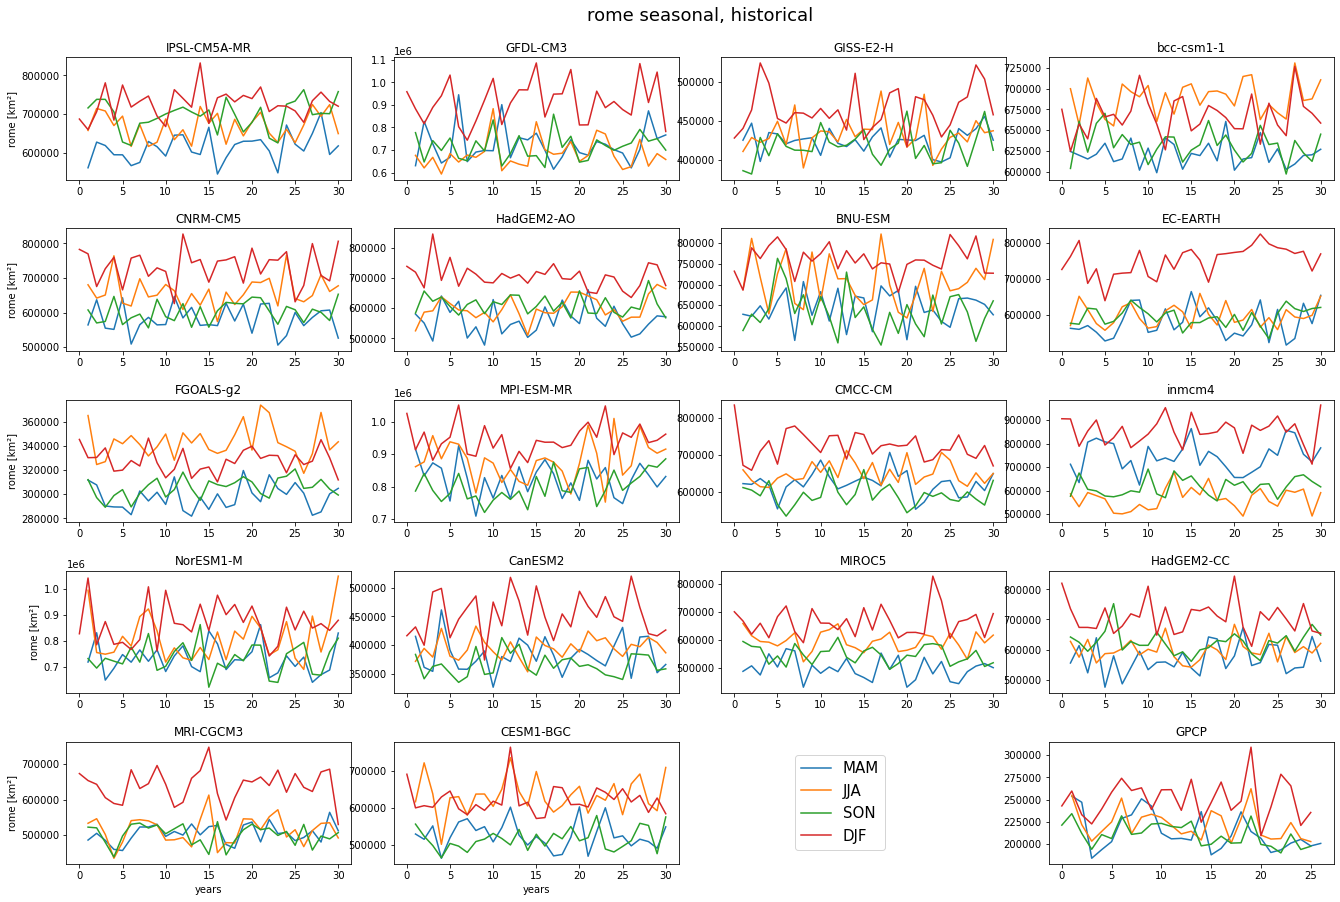

In [12]:
f, axes = plt.subplots(nrows=5, ncols=4, figsize = (22,14))
f.suptitle(rome_option + ' seasonal, ' + experiment, fontsize=18, y=0.95)

for model, ax in zip(models, axes.ravel()):

    folder = home + '/Documents/data/cmip5/' + model
    fileName = model + '_rome_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)

    season = ds[rome_option].resample(time='QS-DEC').mean(dim="time")
    season = to_monthly(season)
    season = season.rename({'month':'season'})
    season = season.assign_coords(season = ["MAM", "JJA", "SON", "DJF"])

    ax.plot(season, label = season.season.values)
    ax.set_title(model)
    # ax.legend()

    if model == 'MRI-CGCM3' or model == 'CESM1-BGC':
        ax.set_xlabel('years')

    if model == 'IPSL-CM5A-MR' or model == 'CNRM-CM5' or model == 'FGOALS-g2' or model == 'NorESM1-M' or model == 'MRI-CGCM3': 
        ax.set_ylabel(rome_option + ' [km\u00b2]')


if obs['GPCP']:
    ax = axes[-1,-1]
    folder = home + '/Documents/data/obs/GPCP'
    fileName = 'GPCP_rome.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    
    pr_season = ds[rome_option].resample(time='QS-DEC').mean(dim="time")
    pr_season = to_monthly(pr_season)
    pr_season = pr_season.rename({'month':'season'})
    pr_season = pr_season.assign_coords(season = ["MAM", "JJA", "SON", "DJF"])

    ax.plot(pr_season, label = pr_season.season.values)
    ax.set_title('GPCP')
    ax.legend(bbox_to_anchor=(-0.55, 0.95), fontsize=15)


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.4)
axes[-1, 2].remove()

### monthly

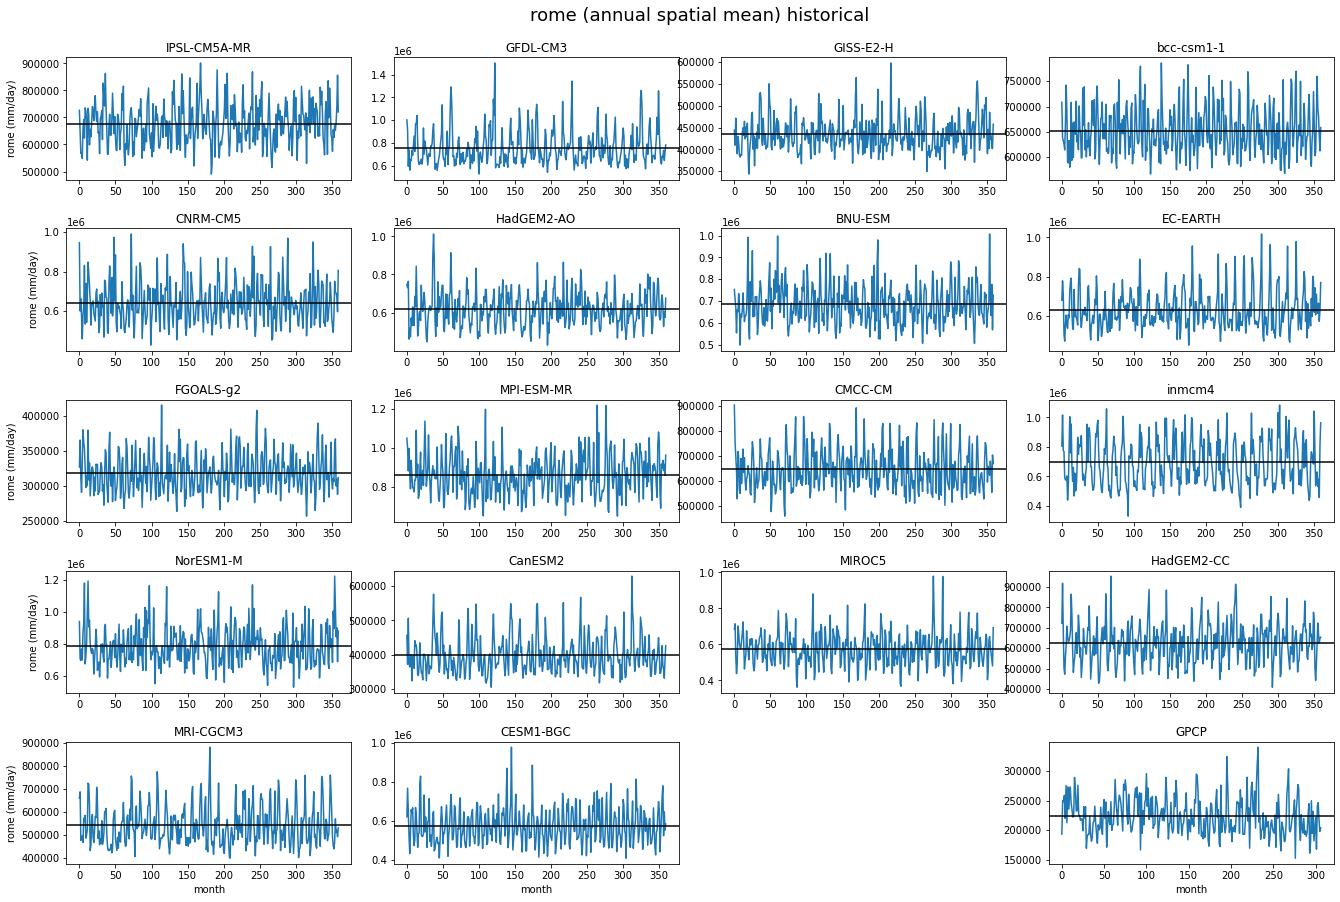

In [15]:
f, axes = plt.subplots(nrows=5, ncols=4, figsize = (22,14))
f.suptitle(rome_option + ' (annual spatial mean) ' + experiment, fontsize=18, y=0.95)

for model, ax in zip(models, axes.ravel()):

    folder = home + '/Documents/data/cmip5/' + model
    fileName = model + '_rome_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)

    ax.plot(ds[rome_option].resample(time='M').mean(dim='time'))
    ax.axhline(y=ds[rome_option].resample(time='M').mean(dim='time').mean(dim='time'), color='k')
    ax.set_title(model)

    if model == 'MRI-CGCM3' or model == 'CESM1-BGC':
        ax.set_xlabel('month')

    if model == 'IPSL-CM5A-MR' or model == 'CNRM-CM5' or model == 'FGOALS-g2' or model == 'NorESM1-M' or model == 'MRI-CGCM3': 
        ax.set_ylabel(rome_option + ' (mm/day)')


if obs['GPCP']:
    ax = axes[-1,-1]
    folder = home + '/Documents/data/obs/GPCP'
    fileName = 'GPCP_rome.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    ax.plot(ds[rome_option].resample(time='M').mean(dim='time'))
    ax.axhline(y=ds[rome_option].resample(time='M').mean(dim='time').mean(dim='time'), color='k')
    ax.set_title('GPCP')
    ax.set_xlabel('month')
    

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.4)
axes[-1, 2].remove()

### daily

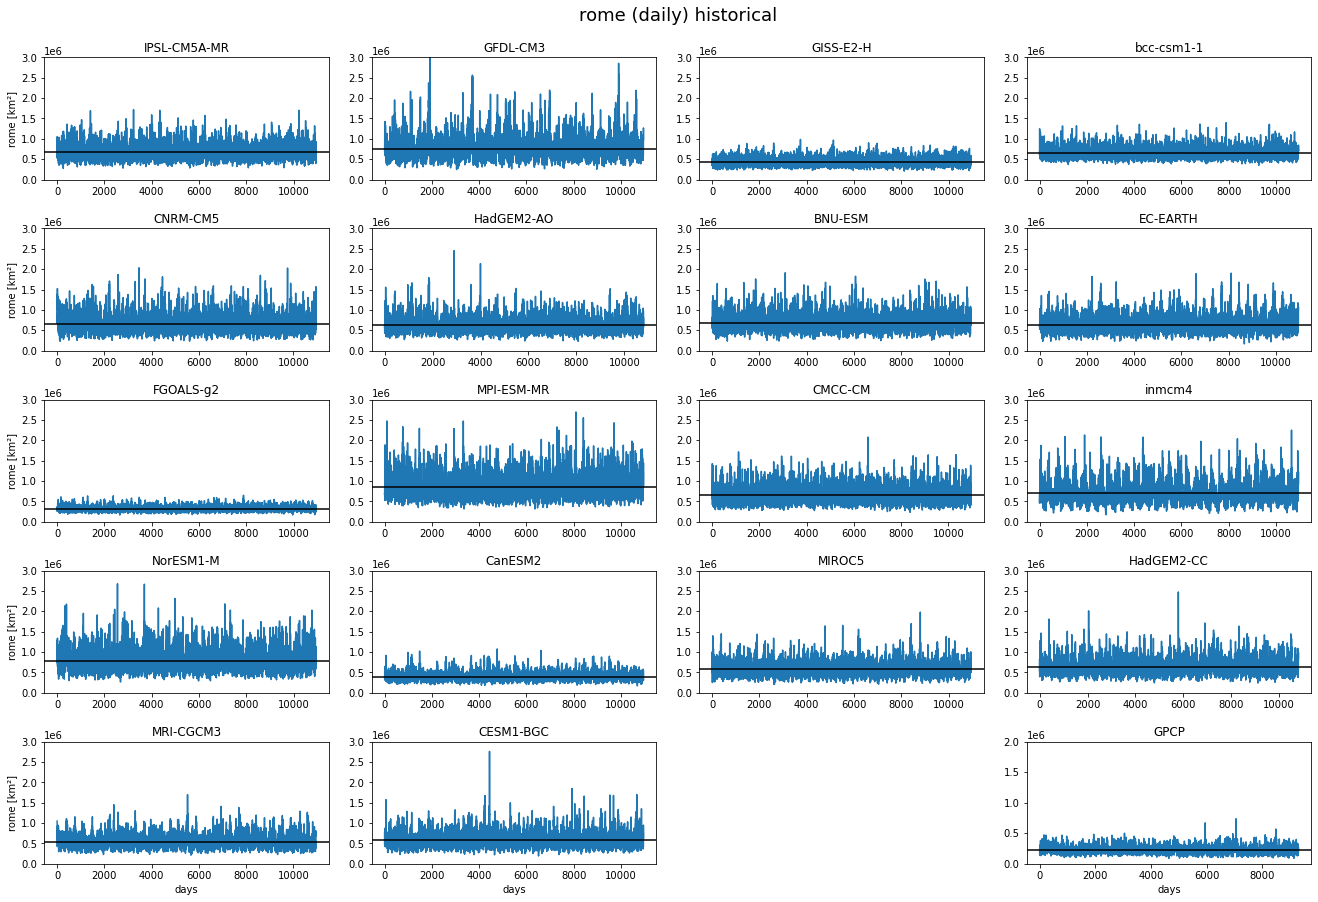

In [18]:
f, axes = plt.subplots(nrows=5, ncols=4, figsize = (22,14))
f.suptitle(rome_option + ' (daily) ' + experiment, fontsize=18, y=0.95)

for model, ax in zip(models, axes.ravel()):

    folder = home + '/Documents/data/cmip5/' + model
    fileName = model + '_rome_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)

    ax.plot(ds[rome_option])
    ax.axhline(y=ds[rome_option].mean(dim='time'), color='k')
    ax.set_title(model)
    ax.set_ylim(0,3e6)

    if model == 'MRI-CGCM3' or model == 'CESM1-BGC':
        ax.set_xlabel('days')

    if model == 'IPSL-CM5A-MR' or model == 'CNRM-CM5' or model == 'FGOALS-g2' or model == 'NorESM1-M' or model == 'MRI-CGCM3': 
        ax.set_ylabel(rome_option + ' [km\u00b2]')


if obs['GPCP']:
    ax = axes[-1,-1]
    folder = home + '/Documents/data/obs/GPCP'
    fileName = 'GPCP_rome.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    ax.plot(ds[rome_option])
    ax.axhline(y=ds[rome_option].mean(dim='time'), color='k')
    ax.set_title('GPCP')
    ax.set_xlabel('days')
    ax.set_ylim(0,2e6)



plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.4)
axes[-1, 2].remove()

## other

### monthly mean

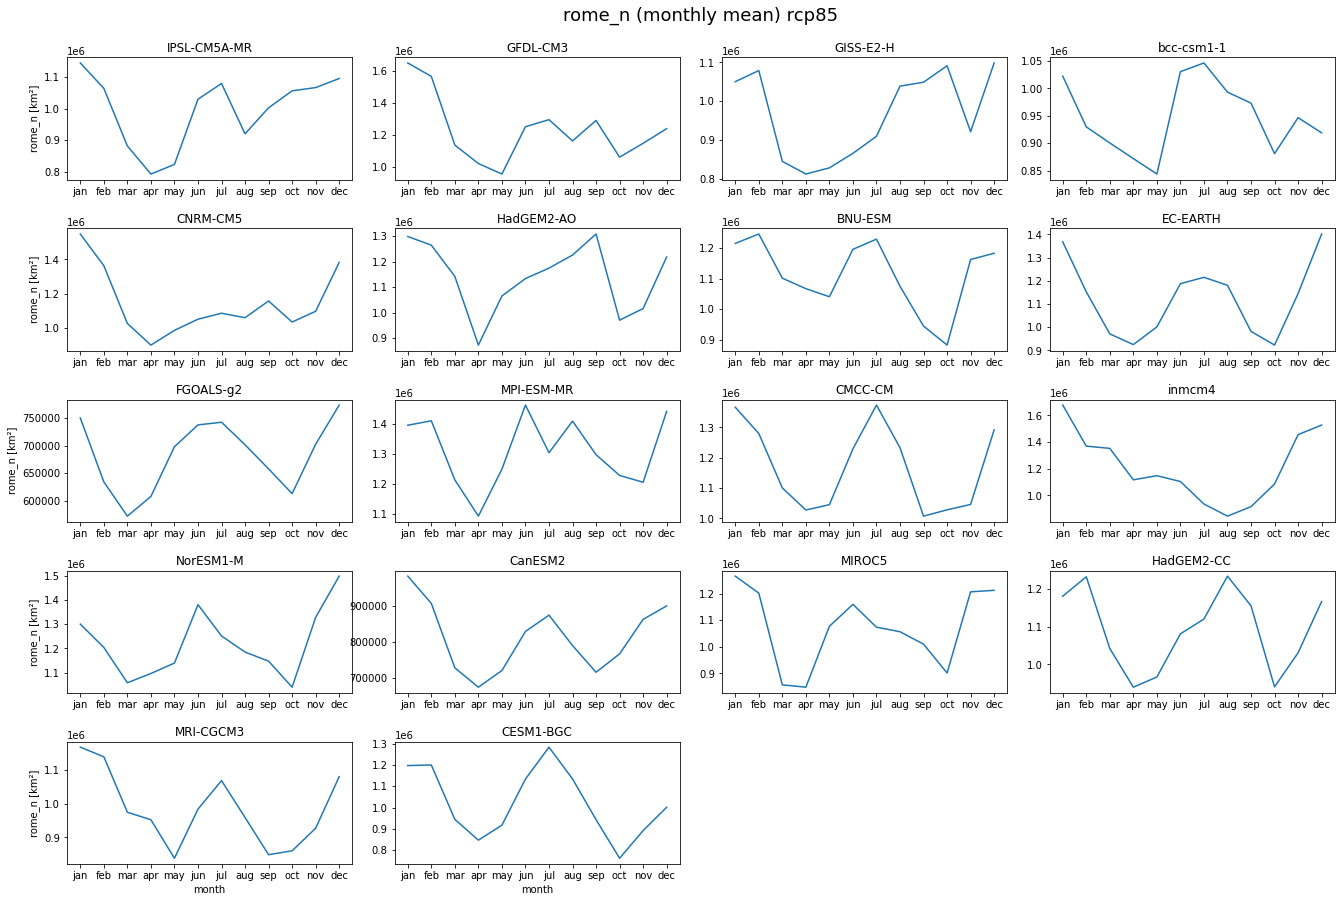

In [ ]:
f, axes = plt.subplots(nrows=5, ncols=4, figsize = (22,14))
f.suptitle(rome_option + ' (monthly mean) ' + experiment, fontsize=18, y=0.95)

for model, ax in zip(models, axes.ravel()):
    if switch['local_files']:
        folder = home + '/Documents/data/cmip5/' + model

    if switch['nci_files']:
        folder = '/g/data/k10/cb4968/data/cmip5/'+ model

    fileName = model + '_rome_' + experiment + '.nc'
    path = folder + '/' + fileName
    rome= xr.open_dataset(path)

    rome_monthly = to_monthly(rome[rome_option])
    rome_monthly = rome_monthly.assign_coords(month = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul','aug', 'sep', 'oct', 'nov', 'dec'])

    ax.plot(rome_monthly.mean(dim='year'))
    ax.set_title(model)
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(rome_monthly.month.values)

    if model == 'MRI-CGCM3' or model == 'CESM1-BGC':
        ax.set_xlabel('month')

    if model == 'IPSL-CM5A-MR' or model == 'CNRM-CM5' or model == 'FGOALS-g2' or model == 'NorESM1-M' or model == 'MRI-CGCM3': 
        ax.set_ylabel(rome_option + ' [km\u00b2]')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.4)
axes[-1, 2].remove()
axes[-1, 3].remove()